# Imports & Setup

In [74]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import mne
import time
from tqdm.notebook import tqdm
from chbmit.chbmit import FilteredCMP, STFT, CHB_MIT_PAITENT, stft
import torchmetrics
from mlutils import train
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import gc

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [3]:
torch.manual_seed(0)

In [4]:
regression_data = FilteredCMP(16, 32, "/workspace/physionet.org/files/chbmit/1.0.0/chb01", 3600, 0, regression=True, use_tok_dim=False)
classification_data = FilteredCMP(16, 32, "/workspace/physionet.org/files/chbmit/1.0.0/chb01", 3600, 0, regression=False, use_tok_dim=False)

  0%|          | 0/9992 [00:00<?, ?it/s]

  0%|          | 0/10217 [00:00<?, ?it/s]

In [5]:
class RegressionOnly(torch.utils.data.Dataset):
  def __init__(self, raw_data):
    self.data = raw_data
    self.filtered_idx_list = []
    for i in tqdm(range(len(self.data))):
      data, label = self.data[i]
      if((np.abs(data) > 1e-8).astype(np.longlong).sum() / data.size > .98 and label != float('inf')):
        self.filtered_idx_list.append(i)

  def __len__(self):
    return len(self.filtered_idx_list)
  
  def __getitem__(self, idx):
    return self.data[self.filtered_idx_list[idx]]

In [6]:
training_regression_data, test_regression_data = torch.utils.data.random_split(regression_data, [.80, .20])
training_class_data, test_class_data = torch.utils.data.random_split(classification_data, [.80, .20])

test_dataloader = torch.utils.data.DataLoader(test_regression_data, batch_size=32, num_workers=4)

In [7]:
reg_folds = torch.utils.data.random_split(training_regression_data, [.20, .20, .20, .20, .20])

# Baseline CNN classifier (no STFT)

## Model & Data Init.

In [85]:
class SimpleConv(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.feat_exctract = torch.nn.Sequential(torch.nn.Conv1d(23, 64, (5)),
                                             torch.nn.ReLU(),
                                             torch.nn.MaxPool1d((3)),
                                             torch.nn.Conv1d(64, 32, (5)),
                                             torch.nn.ReLU(),
                                             torch.nn.MaxPool1d((3)),
                                             torch.nn.Conv1d(32, 16, (5)),
                                             torch.nn.ReLU(),
                                             torch.nn.MaxPool1d((3)),
                                             torch.nn.Conv1d(16, 8, (5)),
                                             torch.nn.ReLU(),
                                             torch.nn.MaxPool1d((3)),
                                             torch.nn.Conv1d(8, 4, (5)),
                                             torch.nn.ReLU(),
                                             torch.nn.MaxPool1d((3)),
                                             torch.nn.Flatten())
    self.class_head = torch.nn.Sequential(torch.nn.Linear(2148, 128),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(128, 2))

  def forward(self, data):
    return self.class_head(self.feat_exctract(data))

CNN = SimpleConv().to(device)

In [78]:
batch_size = 30
learning_rate = 1e-4

training_data, val_data, test_data = torch.utils.data.random_split(classification_data, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,)

In [79]:
optim = torch.optim.Adam(CNN.parameters(), lr=learning_rate, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss(torch.Tensor([1.16, 7.23]).to(device))

## Training & Validation

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/envs/ss/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 40/40 [14:19<00:00, 21.48s/it]


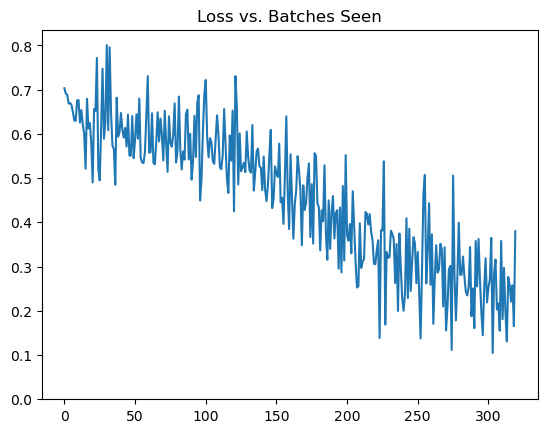

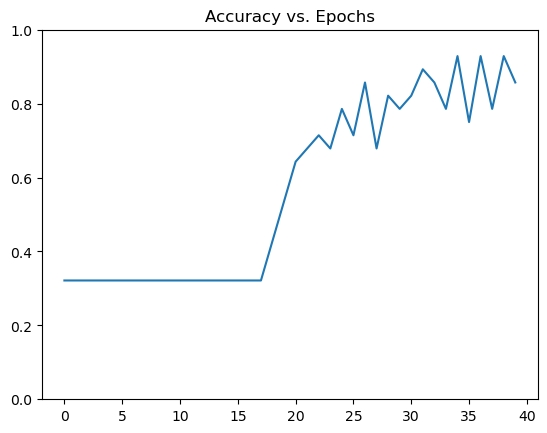

In [80]:
epochs=70
losses = []
accuracy = []
best_accuracy = 0
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_classifcation(CNN, train_dataloader, optim, loss_fn=loss_fn, device=device))
  TP, TN, FP, FN = train.validate_binary_softmax(CNN, val_dataloader, device=device)
  if((TP + TN) / (TP + FP + TN + FN) > best_accuracy):
    torch.save(CNN.state_dict(), "CNN.pt")
    best_accuracy = (TP + TN) / (TP + FP + TN + FN)
  accuracy.append((TP + TN) / (TP + FP + TN + FN))

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Accuracy vs. Epochs")
plt.plot(accuracy)
plt.ylim((0, 1))
plt.show()

In [83]:
TP, TN, FP, FN = train.validate_binary_softmax(CNN, test_dataloader, device=device)
print(f"Sensitivity: {TP / (TP + FN)}")
print(f"Specificity: {TN / (TN + FP)}")
print(f"Accuracy: {(TP + TN) / (TP + FP + TN + FN)}")
print(f"FPR/h {FP / (FP + TN) / (1 / 6)}")

Sensitivity: 1.0
Specificity: 0.9545454545454546
Accuracy: 0.9629629629629629
FPR/h 0.27272727272727276


In [82]:
CNN.load_state_dict(torch.load("CNN.pt"))

<All keys matched successfully>

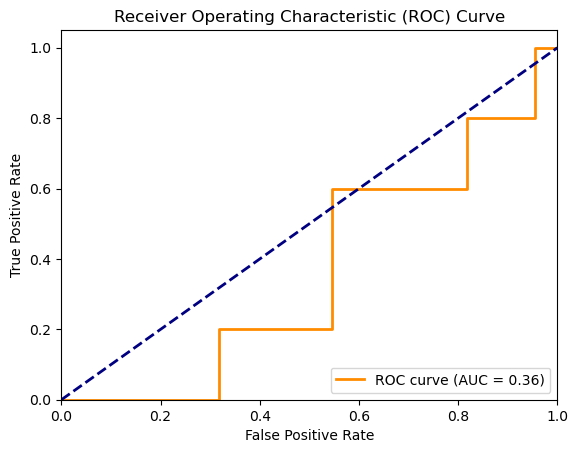

0.36363636363636365

In [86]:
train.validate_binary_auc(CNN, test_dataloader, device=device)

# Baseline CNN classifier (STFT)

## Model & Data Init.

In [4]:
CESP = torch.nn.Sequential(
  STFT(10 * 256, 10 * 256, device=device),
  torch.nn.Conv2d(23, 126, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Conv2d(126, 64, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Conv2d(64, 64, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Flatten(),
  torch.nn.Linear(40448, 4096),
  torch.nn.ReLU(),
  torch.nn.Linear(4096, 256),
  torch.nn.ReLU(),
  torch.nn.Linear(256, 2),
).to(device)

/opt/conda/envs/ss/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
batch_size = 30
learning_rate = 1e-4

training_data, val_data, test_data = torch.utils.data.random_split(classification_data, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,)

In [6]:
optim = torch.optim.Adam(CESP.parameters(), lr=learning_rate, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss(torch.Tensor([1.16, 7.23]).to(device))

/opt/conda/envs/ss/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training & Validation

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/envs/ss/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 40/40 [23:28<00:00, 35.21s/it]


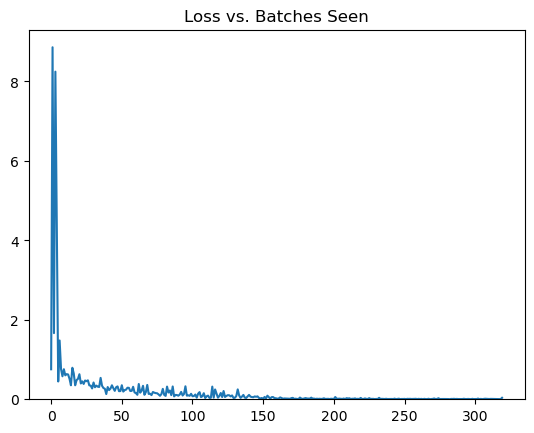

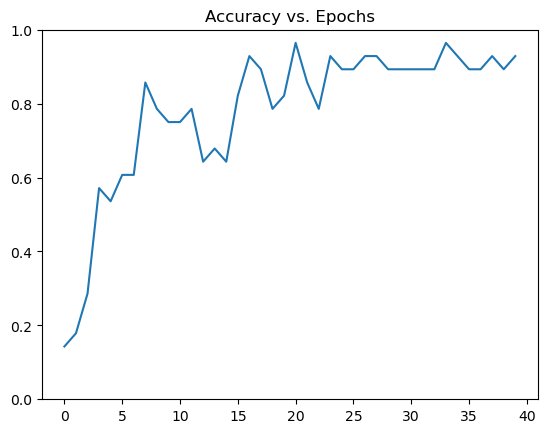

In [7]:
epochs=40
losses = []
accuracy = []
best_accuracy = 0
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_classifcation(CESP, train_dataloader, optim, loss_fn=loss_fn, device=device))
  TP, TN, FP, FN = train.validate_binary_softmax(CESP, val_dataloader, device=device)
  if((TP + TN) / (TP + FP + TN + FN) > best_accuracy):
    torch.save(CESP.state_dict(), "CESP.pt")
    best_accuracy = (TP + TN) / (TP + FP + TN + FN)
  accuracy.append((TP + TN) / (TP + FP + TN + FN))

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Accuracy vs. Epochs")
plt.plot(accuracy)
plt.ylim((0, 1))
plt.show()

In [8]:
TP, TN, FP, FN = train.validate_binary_softmax(CESP, test_dataloader, device=device)
print(f"Sensitivity: {TP / (TP + FN)}")
print(f"Specificity: {TN / (TN + FP)}")
print(f"Accuracy: {(TP + TN) / (TP + FP + TN + FN)}")
print(f"FPR/h {FP / (FP + TN) / (1 / 6)}")

Sensitivity: 0.8571428571428571
Specificity: 0.9
Accuracy: 0.8888888888888888
FPR/h 0.6000000000000001


In [9]:
CESP.load_state_dict(torch.load("CESP.pt"))

<All keys matched successfully>

In [10]:
len(test_data)

27

  0%|          | 0/1 [00:00<?, ?it/s]

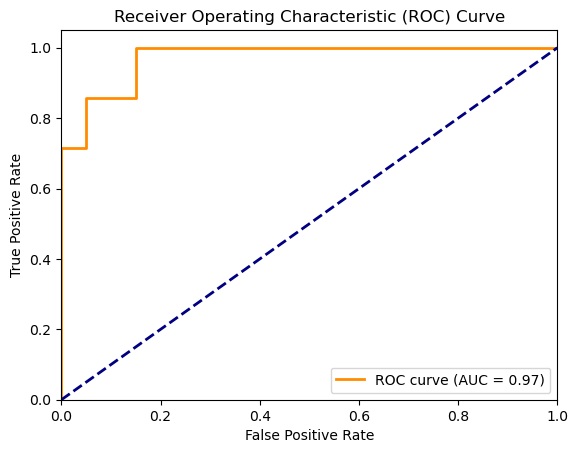

0.9714285714285714

In [11]:
train.validate_binary_auc(CESP, test_dataloader, device=device)

# NLL Heteroscedastic (w/ improvements)

**Improvements Made**: 
  - Loss decomposed into classification, regression, and entropy.
  - We weight the classifaction loss using the formula $\frac{N_{total}}{N_{class}}$
  - We minimize the variance directly instead of minimizing entropy

**Notes on Defualt Behavior w/o improvements**:
  - Generally will converge, you'll see two flat regions w/ a phase transition in between when the model learns the classifcation loss. It will improve marginally on the regression loss.
  - Windows tend to be unusably wide
  - Regression Not accurate
  - Classifcation prediction is unconfident and wrong

**Notes on Default Behavior w/ improvements**:
  - In first part of the curve, we see a larger regression loss with classification loss balencing out fairly quickly. Loss is driven to zero fast.
  - Loss isn't really correlated with accuracy after a certain point. Accuracy will continue to improve even after loss stops meaningfully decreasing
  - Large varience in how well training runs do

## Model and Data Init.

In [ ]:
sample = torch.Tensor([label.item() for data, label in reg_train if label != float('inf')])
norm=(sample.mean().item(), sample.std().item()/(1 ** 0.5))
pos_weight = len(sample) / len(reg_train)
neg_weight = 1 - pos_weight
pos_weight = 1 / pos_weight
neg_weight = 1 / neg_weight

In [8]:
pos_weight = 6
neg_weight = 1

In [26]:
class REGCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
          STFT(10 * 256, 10 * 256, device=device),
          torch.nn.Conv2d(23, 126, (3, 3)),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d((2, 2)),
          torch.nn.Conv2d(126, 64, (3, 3)),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d((2, 2)),
          torch.nn.Conv2d(64, 64, (3, 3)),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d((2, 2)),
          torch.nn.Flatten(),
          torch.nn.Linear(40448, 4096),
          torch.nn.ReLU(),
          torch.nn.Linear(4096, 256),
          torch.nn.ReLU(),
          torch.nn.Linear(256, 3),
        )

    def training_step(self, batch, batch_idx):
        data, label = batch
        pred = self.model(data)
        classifcation_loss = 0
        loss = torch.zeros_like(label).float()
        prob = torch.nn.functional.sigmoid(pred[..., 0])
        mean = pred[..., 1][(label != float('inf'))]
        var = torch.square(pred[..., 2][(label != float('inf'))])
        loss[(label == float('inf'))] = -torch.log(1 - prob[(label == float('inf'))] + 1e-8) * neg_weight
        loss[(label != float('inf'))] = -torch.log(prob[(label != float('inf'))] + 1e-8) * pos_weight
        classifcation_loss = loss.mean(dim=-1)
        self.log('classification_loss', classifcation_loss)
        # loss[(label != float('inf'))] += torch.log((label[(label != float('inf'))] - mean) ** 2) - torch.log(2 * var)
        loss[(label != float('inf'))] += ((label[(label != float('inf'))] - mean) ** 2) / (2 * var)
        # loss[(label != float('inf'))] += torch.log(torch.sqrt(2 * torch.pi * var)) # entropy
        loss[(label != float('inf'))] += torch.sqrt(var)
        self.log('regression_loss', loss.mean(dim=-1) - classifcation_loss)
        self.log('train_loss', loss.mean(dim=-1))
        return loss.mean(dim=-1)

    def validation_step(self, batch, batch_step):
        TP, TN, FP, FN = 0, 0, 0, 0
        data, label = batch
        data = data.float()
        label = label.float()
        prob = self.model(data)[..., 0]
        pred = torch.zeros_like(prob)
        pred[prob > 0.5] = 1
        
        TN += ((pred == 0) & (label == float('inf'))).sum(dim=-1).item()
        FN += ((pred == 0) & (label != float('inf'))).sum(dim=-1).item()
        TP += ((pred == 1) & (label != float('inf'))).sum(dim=-1).item()
        FP += ((pred == 1) & (label == float('inf'))).sum(dim=-1).item()
        self.log('acc', (TP + TN) / (TP + FP + TN + FN))
        if TP + FN != 0:
            self.log('sens', TP / (TP + FN))
        if TN + FP != 0:
            self.log('spec', TN / (TN + FP))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-2)


In [91]:
L.pytorch.utilities.memory.garbage_collection_cuda()
torch.cuda.memory_allocated()
# Function to delete all CUDA tensors
def delete_all_cuda_tensors():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                del obj
        except:
            pass
    # Call garbage collector to free up memory
    gc.collect()
    torch.cuda.empty_cache()

# Example usage
delete_all_cuda_tensors()

In [27]:
for i in range(len(reg_folds)):
    print(f'FOLD {i}')
    print('--------------------------------')
    L.pytorch.utilities.memory.garbage_collection_cuda()
    
    # Prepare the training and validation datasets
    val_dataset = reg_folds[i]
    train_datasets = [reg_folds[j] for j in range(len(reg_folds)) if j != i]
    
    # Combine training datasets
    train_dataset = torch.utils.data.ConcatDataset(train_datasets)
    
    # Define data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=4)

    # Initialize model
    model = REGCNN()

    early_stopping = EarlyStopping(
        monitor='acc',
        patience=5,
        verbose=True,
        mode='max'
    )

    checkpoint_callback = ModelCheckpoint(
        monitor='acc',       # Metric to monitor
        dirpath='REGCNN/',       # Directory to save the model checkpoints
        filename=f'best-reg-{i}.pt', # Name of the saved model file
        save_top_k=1,             # Save only the top 1 model
        mode='max'                # Mode for the monitored metric ('min' for loss, 'max' for accuracy)
    )
    logger = TensorBoardLogger('tb_logs', name='NLL_HET_std_pen')
    trainer = L.Trainer(max_epochs=15, accelerator='auto', strategy='auto', callbacks=[early_stopping, checkpoint_callback], logger=logger)
    trainer.fit(model, train_loader, val_loader)

FOLD 0
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/NLL_HET_std_pen
/opt/conda/envs/ss/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /workspace/SeizureSense/REGCNN exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 166 M  | train
---------------------------------------------
166 M     Trainable params
0         Non-trainable params
166 M     Total params
667.458   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved. New best score: 0.833


Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.030 >= min_delta = 0.0. New best score: 0.863


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.008 >= min_delta = 0.0. New best score: 0.871


Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.008 >= min_delta = 0.0. New best score: 0.879


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.004 >= min_delta = 0.0. New best score: 0.883


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.017 >= min_delta = 0.0. New best score: 0.900


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


FOLD 1
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 166 M  | train
---------------------------------------------
166 M     Trainable params
0         Non-trainable params
166 M     Total params
667.458   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved. New best score: 0.889


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.010 >= min_delta = 0.0. New best score: 0.899


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.005 >= min_delta = 0.0. New best score: 0.904


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.001 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


FOLD 2
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 166 M  | train
---------------------------------------------
166 M     Trainable params
0         Non-trainable params
166 M     Total params
667.458   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved. New best score: 0.885


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.004 >= min_delta = 0.0. New best score: 0.889


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric acc did not improve in the last 5 records. Best score: 0.889. Signaling Trainer to stop.


FOLD 3
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 166 M  | train
---------------------------------------------
166 M     Trainable params
0         Non-trainable params
166 M     Total params
667.458   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved. New best score: 0.884


Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.003 >= min_delta = 0.0. New best score: 0.887


Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.005 >= min_delta = 0.0. New best score: 0.892


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric acc did not improve in the last 5 records. Best score: 0.892. Signaling Trainer to stop.


FOLD 4
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 166 M  | train
---------------------------------------------
166 M     Trainable params
0         Non-trainable params
166 M     Total params
667.458   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.217 >= min_delta = 0.0. New best score: 0.877


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.007 >= min_delta = 0.0. New best score: 0.884


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric acc improved by 0.010 >= min_delta = 0.0. New best score: 0.894


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


## Training & Validation

In [70]:
model = REGCNN.load_from_checkpoint('/workspace/SeizureSense/REGCNN/best-reg-1.pt-v1.ckpt')

In [72]:
# Seeing how individual examples fair
idx = 43
pred = model.model.to(device)(torch.Tensor(test_regression_data[idx][0]).unsqueeze(0))
print(pred)
print(torch.sigmoid(pred[0, 0]).item())
print(f"95%: {(pred[0, 1] - torch.abs(pred[0, 2]) * 2) / 60} {(pred[0, 1] + torch.abs(pred[0, 2]) * 2) / 60}")
print(f"Center {(pred[0, 1]) / 60}")
print((test_regression_data[idx][1] / 60))


tensor([[   4.6876, 1621.0851,  -90.2948]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0.990875244140625
95%: 24.008258819580078 30.027912139892578
Center 27.018085479736328
12.733333333333333


In [88]:

acc = torchmetrics.classification.Accuracy(task='binary',).to(device)
for data, label in test_dataloader:
  pred = torch.sigmoid(model.model(data)[..., 0])
  zero = (label == float('inf'))
  label[zero] = 0
  label[~zero] = 1
  acc(pred.to(device), label.to(device))
acc.compute()

tensor(0.8438, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.7812, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0

tensor(0.8861, device='cuda:0')

In [94]:
auprc = torchmetrics.classification.AveragePrecision(task='binary',).to(device)
for data, label in test_dataloader:
  pred = torch.sigmoid(model.model(data)[..., 0])
  zero = (label == float('inf'))
  label[zero] = 0
  label[~zero] = 1
  auprc(pred.to(device), label.to(device).long())
auprc.compute()

/opt/conda/envs/ss/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


tensor(0.7459, device='cuda:0')

In [14]:
# Seeing how individual examples fair
idx = 500
pred = model.model.to(device)(torch.Tensor(regression_data[idx][0]).unsqueeze(0))
print(pred)
print(torch.sigmoid(pred[0, 0]).item())
print(f"95%: {pred[0, 1] - torch.abs(pred[0, 2])} {pred[0, 1] + torch.abs(pred[0, 2])}")
print(f"95%: {((pred[0, 1] - torch.abs(pred[0, 2]) * 2) * norm[1] + norm[0]) / 60} {((pred[0, 1] + torch.abs(pred[0, 2]) * 2) * norm[1] + norm[0]) / 60}")
print(f"Center {(pred[0, 1] * norm[1] + norm[0]) / 60}")
print((regression_data[idx][1] - norm[0]) / norm[1], (regression_data[idx][1] / 60))


tensor([[ 1.1413e+00,  1.2400e+03, -1.0318e+03]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0.757921576499939
95%: 208.22607421875 2271.85986328125


NameError: name 'norm' is not defined

In [34]:
(0.2082 +  * norm[1] + norm[0]) / 60

32.57749437398275

In [46]:
#Seeing a summary on test data
TP, TN, FP, FN = validate_binary_sigmoid(REGCNN, val_dataloader, device=device)
print(TP, TN, FP, FN)
print(f"Sensitivity: {TP / (TP + FN)}")
print(f"Specificity: {TN / (TN + FP)}")
print(f"Accuracy: {(TP + TN) / (TP + FP + TN + FN)}")
print(f"FPR/h {FP / (FP + TN) / (1 / 6)}")

  0%|          | 0/47 [00:00<?, ?it/s]

0 1161 0 231
Sensitivity: 0.0
Specificity: 1.0
Accuracy: 0.834051724137931
FPR/h 0.0


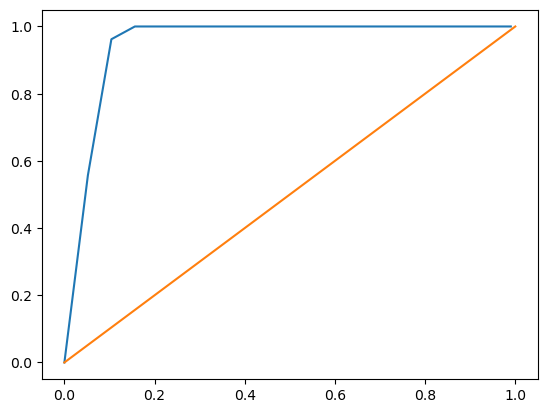

In [38]:
@torch.inference_mode()
def plot_calibration():
  n = torch.distributions.normal.Normal(0, 1)
  ans = []
  for p in torch.linspace(0, .99, 20):
    z = n.icdf(p + (1 - p) / 2).item()
    cnt = 0
    for data, label in ronly_data:
      d = torch.Tensor(data).unsqueeze(0)
      l = (label.item() - norm[0]) / norm[1]
      mean, std = REGCNN(d)[0, 1:]
      if l >= mean.item() - std.abs().item() * z and l <= mean.item() + std.abs().item() * z:
        cnt+=1

    cnt/=len(ronly_data)
    ans.append(cnt)

  plt.plot(np.linspace(0, .99, 20), ans)
  plt.plot([0, 1], [0, 1])
  plt.show()    

plot_calibration()

# Multi-Head Hetroscedastic

## Models and Data Init.

In [141]:
class MultHeadCNN(L.LightningModule):
  def __init__(self):
    super().__init__()
    self.feature_extract = torch.nn.Sequential(
    STFT(10 * 256, 10 * 256, device=device),
      torch.nn.Conv2d(23, 126, (3, 3)),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d((2, 2)),
      torch.nn.Conv2d(126, 64, (3, 3)),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d((2, 2)),
      torch.nn.Conv2d(64, 64, (3, 3)),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d((2, 2)),
      torch.nn.Flatten(),
      torch.nn.Linear(40448, 4096),
      torch.nn.ReLU(),
    )
    self.classifcation_head = torch.nn.Sequential(
      torch.nn.Linear(4096, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 2),
    )
    self.regression_head = torch.nn.Sequential(
      torch.nn.Linear(4096, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 1),
    )
    self.variance_head = torch.nn.Sequential(
      torch.nn.Linear(4096, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 1),
    )
    self.mode_val = 0 # classifcation, regression, window

  def training_step(self, batch, batch_idx):
    features = self.feature_extract(batch)
    if self.mode_val == 0:
      self.classifcation_head(features)
    elif self.mode_val == 1:
      self.regression_head(features).flatten()
    else:
      reg = self.regression_head(features).detach()
      mean, var = reg.flatten(), self.variance_head(features).flatten() ** 2

  def mode(self, mode):
    self.mode_val = mode
MHCNN = MultHeadCNN().to(device)

In [91]:
batch_size = 30
learning_rate = 1e-4

training_data, val_data, test_data = torch.utils.data.random_split(classification_data, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,)

reg_training_data, reg_val_data, reg_test_data = torch.utils.data.random_split(ronly_data, [0.8, 0.1, 0.1])
reg_train_dataloader = torch.utils.data.DataLoader(reg_training_data, batch_size=batch_size, shuffle=True)
reg_val_dataloader = torch.utils.data.DataLoader(reg_val_data, batch_size=batch_size,)
reg_test_dataloader = torch.utils.data.DataLoader(reg_test_data, batch_size=batch_size,)

In [92]:
def HSRLoss(pred, label):
  mean = pred[0]
  var = pred[1]
  loss = torch.zeros_like(label)
  loss += ((label - mean) ** 2) / (2 * (var ** 2))
  loss += torch.log(2 * torch.pi * (var ** 2)) / 2
  return loss.mean(dim=-1)

In [93]:
def train_epoch_regression(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, optim: torch.optim.Optimizer, loss_fn = torch.nn.MSELoss(), device=torch.device('cpu'), norm: tuple = (0, 1)) -> list[float]:
  '''
  Args:
    model 
      The model being trained
    dataloader
      The training dataloader
    optim
      The optimizer to use for training
    loss_fn
      (defaults to torch.nn.MSELoss()) the regresison loss to use
    device
      The device on which to train on
    norm : tuple
      A shifting and scaling constant, in that order

  Returns:
    losses: a list of losses for every batch in the epoch
  '''
  losses = []
  for (data, label) in dataloader:
    data = data.to(device).float()
    label = (label.to(device).float() - norm[0]) / norm[1]
    pred = model(data)
    loss = loss_fn(pred, label)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.append(loss.item())
  return losses

In [94]:
optim = torch.optim.Adam(MHCNN.parameters(), lr=learning_rate, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss(torch.Tensor([1.16, 7.23]).to(device))

## Training & Validation

### Training the Classifier

In [149]:
MHCNN.mode(0)

100%|██████████| 40/40 [22:12<00:00, 33.32s/it]


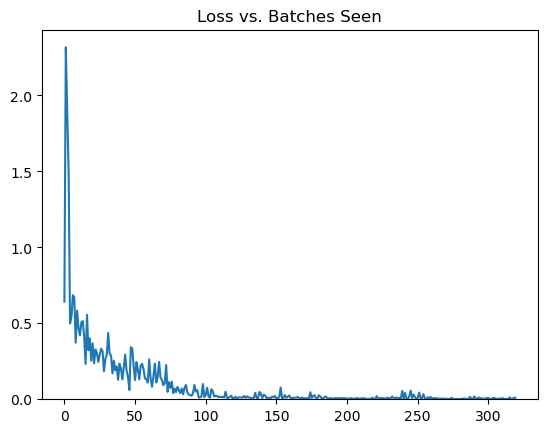

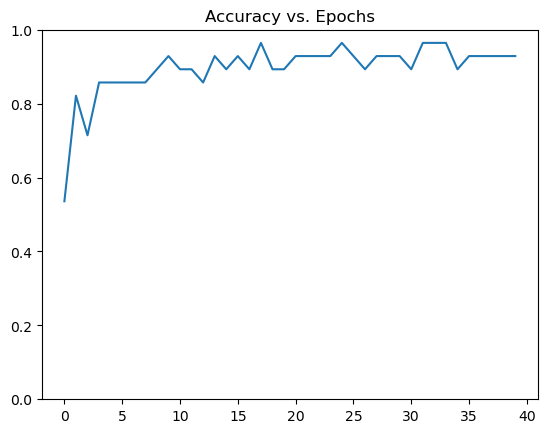

In [29]:
epochs=40
losses = []
accuracy = []
best_accuracy = 0
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_classifcation(MHCNN, train_dataloader, optim, loss_fn=loss_fn, device=device))
  TP, TN, FP, FN = train.validate_binary_softmax(MHCNN, val_dataloader, device=device)
  if((TP + TN) / (TP + FP + TN + FN) > best_accuracy):
    torch.save(MHCNN.state_dict(), "MHCNN.pt")
    best_accuracy = (TP + TN) / (TP + FP + TN + FN)
  accuracy.append((TP + TN) / (TP + FP + TN + FN))

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Accuracy vs. Epochs")
plt.plot(accuracy)
plt.ylim((0, 1))
plt.show()

In [150]:
MHCNN.load_state_dict(torch.load("MHCNN.pt"))

<All keys matched successfully>

In [151]:
TP, TN, FP, FN = train.validate_binary_softmax(MHCNN, test_dataloader, device=device)
print(TP, TN, FP, FN)
print(f"Sensitivity: {TP / (TP + FN)}")
print(f"Specificity: {TN / (TN + FP)}")
print(f"Accuracy: {(TP + TN) / (TP + FP + TN + FN)}")
print(f"FPR/h {FP / (FP + TN) / (1 / 6)}")

9 17 1 0
Sensitivity: 1.0
Specificity: 0.9444444444444444
Accuracy: 0.9629629629629629
FPR/h 0.3333333333333333


### Training the Windowing Function

In [152]:
sample = torch.Tensor([label.item() for data, label in ronly_data])
norm=(sample.mean().item(), sample.std().item()/(1 ** 0.5))

#### Regression

In [153]:
# Training Regression First
MHCNN.mode(1)

100%|██████████| 40/40 [05:52<00:00,  8.82s/it]


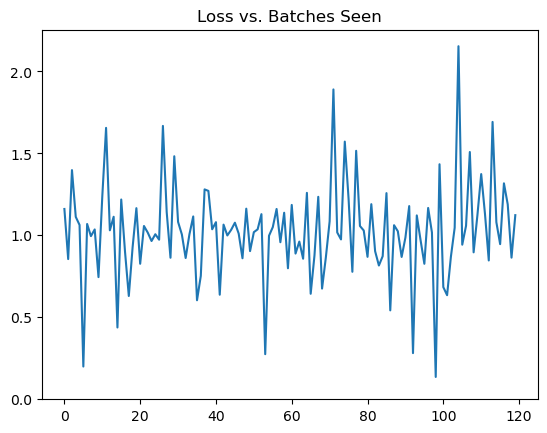

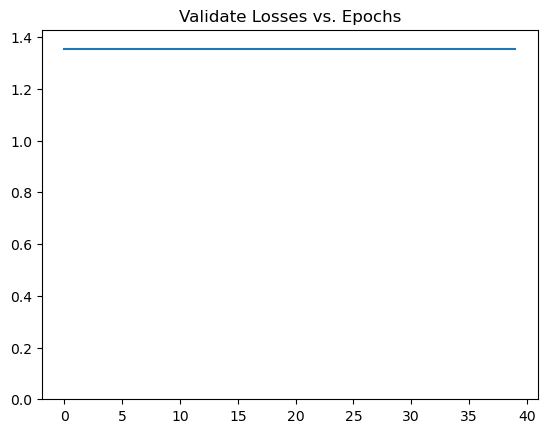

In [154]:
epochs=40
losses = []
val_losses = []
best_loss = float('inf')
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_regression(MHCNN, reg_train_dataloader, optim=optim, device=device, norm=norm))
  val_loss = train.validate_epoch_regression(MHCNN, reg_val_dataloader, device=device, norm=norm)
  val_loss = sum(val_loss) / len(val_loss)
  if(val_loss < best_loss):
    torch.save(MHCNN.state_dict(), "MHCNN_R.pt")
    best_loss = val_loss
  val_losses.append(val_loss)

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Validate Losses vs. Epochs")
plt.plot(val_losses)
plt.ylim(bottom=0)
plt.show()

In [155]:
MHCNN.load_state_dict(torch.load("MHCNN_R.pt"))

<All keys matched successfully>

In [156]:
test_loss = train.validate_epoch_regression(MHCNN, reg_test_dataloader, device=device, norm=norm)
test_loss = sum(test_loss) / len(test_loss)
print(((test_loss ** 0.5) * norm[1]) / 60)

42.14907665534306


#### Variance

In [136]:
# Training Varience
MHCNN.mode(2)

In [138]:
@torch.inference_mode()
def get_brier():
  dataset = reg_test_data
  n = torch.distributions.normal.Normal(0, 1)
  brier = 0
  for p in torch.linspace(0, .99, 20):
    z = n.icdf((1 + p) / 2).item()
    for data, label in dataset:
      d = torch.Tensor(data).unsqueeze(0)
      l = (label.item() - norm[0]) / norm[1]
      mean, std = MHCNN(d)
      if l >= mean.item() - std.item() * z and l <= mean.item() + std.item() * z:
        brier += (1 - p) ** 2
      else: 
        brier += (p) ** 2
  
  brier/=len(dataset) * 20
  return brier.item()

100%|██████████| 40/40 [14:40<00:00, 22.02s/it]


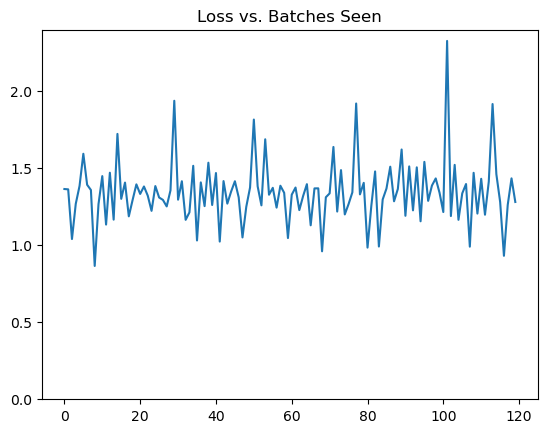

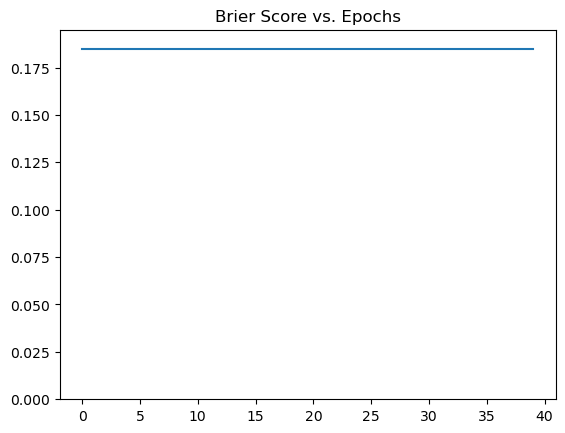

In [139]:
epochs=40
losses = []
val_losses = []
best_loss = float('inf')
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_regression(MHCNN, reg_train_dataloader, optim=optim, loss_fn=HSRLoss, device=device, norm=norm))
  val_loss = get_brier()
  if(val_loss < best_loss):
    torch.save(MHCNN.state_dict(), "MHCNN_V.pt")
    best_loss = val_loss
  val_losses.append(val_loss)

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Brier Score vs. Epochs")
plt.plot(val_losses)
plt.ylim(bottom=0)
plt.show()

In [114]:
MHCNN.load_state_dict(torch.load("MHCNN_V.pt"))

<All keys matched successfully>

In [115]:
len(ronly_data)

79

In [116]:
# Seeing how individual exmples fare
idx = 3
pred = MHCNN(torch.Tensor(ronly_data[idx][0]).unsqueeze(0))
mean = pred[0].detach()
var = pred[1].detach()
print(var.item(), mean.item())
print(f"95%: {mean - torch.abs(var)} {mean + torch.abs(var)}")
print(f"95%: {((mean - torch.abs(var)) * norm[1] + norm[0]) / 60} {((mean + torch.abs(var)) * norm[1] + norm[0]) / 60}")
print(f"Center {(mean * norm[1] + norm[0]) / 60}")
print((ronly_data[idx][1] - norm[0]) / norm[1], (ronly_data[idx][1] / 60))
print(f"Diff: {((ronly_data[idx][1] / 60) - (mean * norm[1] + norm[0]) / 60).item()} Minutes")


0.6717144250869751 0.5904659032821655
95%: tensor([-0.0812], device='cuda:0') tensor([1.2622], device='cuda:0')
95%: tensor([61.4606], device='cuda:0') tensor([108.6572], device='cuda:0')
Center tensor([85.0589], device='cuda:0')
1.0679413999055585 101.83333333333333
Diff: 16.7744140625 Minutes


In [117]:
@torch.inference_mode()
def analyze_uncert():
  data = [torch.Tensor(data).unsqueeze(0) for data, label in reg_test_data]
  entropy = torch.Tensor([torch.log(torch.e * 2 * torch.pi * torch.square(MHCNN(d)[1])).item() / 2 for d in data])
  std = torch.Tensor([MHCNN(d)[1].item() for d in data])
  return entropy.mean(), entropy.std(), std.mean(), std.std()

analyze_uncert()

(tensor(1.1945), tensor(0.1401), tensor(0.8054), tensor(0.1053))

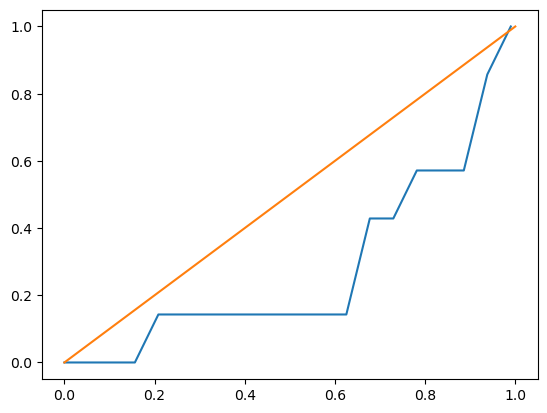

Brier Score: 0.1848161369562149


In [132]:
@torch.inference_mode()
def plot_calibration():
  dataset = reg_test_data
  n = torch.distributions.normal.Normal(0, 1)
  ans = []
  brier = 0
  for p in torch.linspace(0, .99, 20):
    z = n.icdf((1 + p) / 2).item()
    cnt = 0
    for data, label in dataset:
      d = torch.Tensor(data).unsqueeze(0)
      l = (label.item() - norm[0]) / norm[1]
      mean, std = MHCNN(d)
      if l >= mean.item() - std.item() * z and l <= mean.item() + std.item() * z:
        cnt+=1
        brier += (1 - p) ** 2
      else: 
        brier += (p) ** 2

    cnt/=len(dataset)
    ans.append(cnt)
  
  brier/=len(dataset) * 20

  plt.plot(np.linspace(0, .99, 20), ans)
  plt.plot([0, 1], [0, 1])
  plt.show()    
  print(f"Brier Score: {brier}")
  return np.linspace(0, .99, 20), ans, brier

a, b, c = plot_calibration()